In [15]:
%reload_ext watermark
%watermark -v -m -p numpy,matplotlib,sklearn,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 9.0.2

numpy       : 2.2.3
matplotlib  : 3.10.1
sklearn     : 1.6.1
pandas      : 2.2.3
torch       : 2.6.0
transformers: 4.49.0

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


### Load Data

In [85]:
# load data
train_df = pd.read_csv('data/train_split.tsv', sep='\t')
test_df = pd.read_csv('data/test.tsv', sep='\t', header=None, names=['text', 'label'])
val_df = pd.read_csv('data/val_split.tsv', sep='\t')

# test_df.head()
train_df.head()

,text,label
0,graphic sex may be what 's attracting audience...,1
1,perhaps the grossest movie ever made,0
2,"the film is moody , oozing , chilling and hear...",1
3,watching the chemistry between freeman and jud...,1
4,the wonderfully lush morvern callar is pure pu...,1


In [84]:
imdb_train_df = pd.read_csv('data/train_imdb_split.csv')
imdb_val_df = pd.read_csv('data/val_imdb_split.csv')
imdb_test_df = pd.read_csv('data/test_imdb_split.csv')

imdb_train_df.head()

,text,label
0,With no fault to the actors (they all put on g...,0
1,The first thing I thought when I saw this film...,1
2,Post-feminist depiction of cruelty and sadism....,1
3,OMG this is one of the worst films iv ever see...,0
4,"The Box is a film with great potential, but th...",0


### Model

In [3]:
import torch
import torch.nn as nn

class MLP_Model(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP_Model, self).__init__()

        self.layers = nn.ModuleDict({
            "Layer 1": nn.Sequential(
                nn.Linear(input_size, hidden_sizes[0]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 2": nn.Sequential(
                nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 3": nn.Sequential(
                nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 4": nn.Sequential(
                nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ),
            "Layer 5": nn.Linear(hidden_sizes[3], output_size)
        })

    def forward(self, x):
        for name, layer in self.layers.items():
            x = layer(x)
        return x

model = MLP_Model()
print(model)

MLP_Model(
  (layers): ModuleDict(
    (Layer 1): Sequential(
      (0): Linear(in_features=10000, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
    )
    (Layer 5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [4]:
sum_params = 0

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Params: {param.numel()} | Trainable: {param.requires_grad}')
    if param.requires_grad:
        sum_params += param.numel()

print(f'Total Trainable Parameters: {sum_params}')

Layer: layers.Layer 1.0.weight | Size: torch.Size([512, 10000]) | Params: 5120000 | Trainable: True
Layer: layers.Layer 1.0.bias | Size: torch.Size([512]) | Params: 512 | Trainable: True
Layer: layers.Layer 2.0.weight | Size: torch.Size([256, 512]) | Params: 131072 | Trainable: True
Layer: layers.Layer 2.0.bias | Size: torch.Size([256]) | Params: 256 | Trainable: True
Layer: layers.Layer 3.0.weight | Size: torch.Size([128, 256]) | Params: 32768 | Trainable: True
Layer: layers.Layer 3.0.bias | Size: torch.Size([128]) | Params: 128 | Trainable: True
Layer: layers.Layer 4.0.weight | Size: torch.Size([64, 128]) | Params: 8192 | Trainable: True
Layer: layers.Layer 4.0.bias | Size: torch.Size([64]) | Params: 64 | Trainable: True
Layer: layers.Layer 5.weight | Size: torch.Size([2, 64]) | Params: 128 | Trainable: True
Layer: layers.Layer 5.bias | Size: torch.Size([2]) | Params: 2 | Trainable: True
Total Trainable Parameters: 5293122


### Bag-of-words

The bag-of-words model (BoW) is a model of text which uses an unordered collection (a "bag") of words. It disregards word order (and thus most of syntax or grammar) but captures multiplicity.

Each key is the word, and each value is the number of occurrences of that word in the given text document.

```javascript
(1) John likes to watch movies. Mary likes movies too.

(2) Mary also likes to watch football games.
```

Based on these two text documents, a list is constructed as follows for each document:

```javascript
"John","likes","to","watch","movies","Mary","likes","movies","too"

"Mary","also","likes","to","watch","football","games"
```

Representing each bag-of-words as a JSON object, and attributing to the respective JavaScript variable:

```javascript
BoW1 = {"John":1,"likes":2,"to":1,"watch":1,"movies":2,"Mary":1,"too":1};

BoW2 = {"Mary":1,"also":1,"likes":1,"to":1,"watch":1,"football":1,"games":1};
```

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import torch

vectorizer = CountVectorizer(max_features=10000)

X_train_bow = vectorizer.fit_transform(train_df.text)
X_val_bow = vectorizer.transform(val_df.text)
X_test_bow = vectorizer.transform(test_df.text)

y_train = train_df.label
y_val = val_df.label
y_test = test_df.label

#convert to torch tensor
X_train_bow = torch.tensor(X_train_bow.toarray(), dtype=torch.float32)
X_val_bow = torch.tensor(X_val_bow.toarray(), dtype=torch.float32)
X_test_bow = torch.tensor(X_test_bow.toarray(), dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.int32)
y_val = torch.tensor(y_val.values, dtype=torch.int32)
y_test = torch.tensor(y_test.values, dtype=torch.int32)

# df shape
print(len(train_df), len(val_df), len(test_df)) 
print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

5536 1384 1821
torch.Size([5536, 10000]) torch.Size([1384, 10000]) torch.Size([1821, 10000])


In [50]:
import numpy as np

word2idx = vectorizer.vocabulary_
idx2word = {v: k for k, v in word2idx.items()}

print("Original Sentence:", train_df.text.iloc[0].split())

nonzero_indices = X_train_bow[0].nonzero().flatten().numpy()
print("Non-zero indices:", nonzero_indices)

words_in_sentence = [idx2word[idx] for idx in nonzero_indices]
print("Words in BoW representation:", words_in_sentence)

print("Original words in sentences sorted :", sorted(train_df.text.iloc[0].split()))
print(len(train_df.text.iloc[0].split()))
print(len(words_in_sentence))

Original Sentence: ['graphic', 'sex', 'may', 'be', 'what', "'s", 'attracting', 'audiences', 'to', 'unfaithful', ',', 'but', 'gripping', 'performances', 'by', 'lane', 'and', 'gere', 'are', 'what', 'will', 'keep', 'them', 'awake']
Non-zero indices: [ 259  321  399  419  485  751  757 3447 3619 3669 4863 5012 5569 6737
 8445 9314 9393 9589 9837 9870]
Words in BoW representation: ['and', 'are', 'audiences', 'awake', 'be', 'but', 'by', 'gere', 'graphic', 'gripping', 'keep', 'lane', 'may', 'performances', 'sex', 'them', 'to', 'unfaithful', 'what', 'will']
Original words in sentences sorted : ["'s", ',', 'and', 'are', 'attracting', 'audiences', 'awake', 'be', 'but', 'by', 'gere', 'graphic', 'gripping', 'keep', 'lane', 'may', 'performances', 'sex', 'them', 'to', 'unfaithful', 'what', 'what', 'will']
24
20


In [6]:
print({k: vectorizer.vocabulary_[k] for k in list(vectorizer.vocabulary_)[:10]})

{'graphic': np.int64(3619), 'sex': np.int64(8445), 'may': np.int64(5569), 'be': np.int64(485), 'what': np.int64(9837), 'audiences': np.int64(399), 'to': np.int64(9393), 'unfaithful': np.int64(9589), 'but': np.int64(751), 'gripping': np.int64(3669)}


In [7]:
print(len(vectorizer.vocabulary_))

10000


###  Embedding Model bert-base-uncased

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from transformers import AutoTokenizer, AutoModel

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

d:\UserFiles\CS203_Lab_07\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [10]:
bert = AutoModel.from_pretrained(model_name)
print(bert)

embedding_size = bert.config.hidden_size
print('Embedding size:',embedding_size)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
bert.eval()
bert.to(device)

text = 'hello world'
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(inputs['input_ids'])
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

tensor([[ 101, 7592, 2088,  102]])
['[CLS]', 'hello', 'world', '[SEP]']


In [12]:
with torch.no_grad():
    outputs = bert(**inputs.to(device))

embeddings = outputs.last_hidden_state
print('First id:',inputs['input_ids'][0][1])
print('First token:',tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[1])
# print('First embedding:',embeddings[0][0])
print('Embedding shape:',embeddings.shape)


sentence_embeddings = torch.mean(embeddings, dim=1)
print('Sentence embedding shape:',sentence_embeddings.shape)

# CLS : first token, SEP : last token

First id: tensor(7592)
First token: hello
Embedding shape: torch.Size([1, 4, 768])
Sentence embedding shape: torch.Size([1, 768])


In [16]:
def get_bert_embeddings(text, tokenizer, bert, device):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()} 
    with torch.no_grad():
        outputs = bert(**inputs)
    embeddings = outputs.last_hidden_state
    sentence_embeddings = torch.mean(embeddings, dim=1)  # Mean pooling
    return sentence_embeddings.cpu().numpy()

X_val_texts = val_df["text"].tolist()
X_val_bert = get_bert_embeddings(X_val_texts, tokenizer, bert, device)
X_val_bert = torch.tensor(X_val_bert, dtype=torch.float32)
print(X_val_bert.shape)

torch.Size([1384, 768])


In [17]:
X_train_texts = train_df["text"].tolist()
X_train_bert = get_bert_embeddings(X_train_texts, tokenizer, bert, device)
X_train_bert = torch.tensor(X_train_bert, dtype=torch.float32)
print(X_train_bert.shape)

torch.Size([5536, 768])


In [ ]:
X_test_texts = test_df["text"].tolist()
X_test_bert = get_bert_embeddings(X_test_texts, tokenizer, bert, device)
X_test_bert = torch.tensor(X_test_bert, dtype=torch.float32)
print(X_test_bert.shape)

torch.Size([1821, 768])


In [23]:
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([5536]) torch.Size([1384]) torch.Size([1821])


### Training on Dataset I

In [163]:
import torch
import torch.nn as nn

def train(model ,model_path, optimizer , criterion, X_train , y_train , X_val , y_val , num_epochs):
    model.train()

    best_loss = float('inf')
    loss_val = 0
    train_loss_history = []
    val_loss_history = []

    X_train , y_train = X_train.to(device) , y_train.to(device)
    X_val , y_val = X_val.to(device) , y_val.to(device)

    best_model_state = None

    for epoch in range(1,num_epochs+1):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss_train = criterion(y_pred, y_train)

        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            loss_val = criterion(y_pred_val, y_val)
            y_pred_val_class = torch.argmax(y_pred_val, dim=1)
            val_acc = torch.sum(y_pred_val_class == y_val).item() / len(y_val)
            
            print(f'Epoch: {epoch} | Train Loss: {loss_train.item()} | Val Loss: {loss_val.item()} | Val Acc: {val_acc}')

        train_loss_history.append(loss_train.item())
        val_loss_history.append(loss_val.item())

        if epoch == 1:
            best_loss = loss_val
            best_model_state = model.state_dict()

        if loss_val < best_loss:
            best_loss = loss_val
            best_model_state = model.state_dict()
        
    torch.save(best_model_state, model_path)

    return train_loss_history, val_loss_history

In [164]:
# # Example of target with class indices
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# print(input)
# print(target)
# output = loss(input, target)
# print(output)
# output.backward()

Epoch: 1 | Train Loss: 0.6922723054885864 | Val Loss: 0.6924022436141968 | Val Acc: 0.5151734104046243
Epoch: 2 | Train Loss: 0.6915456056594849 | Val Loss: 0.691500723361969 | Val Acc: 0.5151734104046243
Epoch: 3 | Train Loss: 0.6898999810218811 | Val Loss: 0.689597487449646 | Val Acc: 0.5151734104046243
Epoch: 4 | Train Loss: 0.6870383620262146 | Val Loss: 0.6861632466316223 | Val Acc: 0.5151734104046243
Epoch: 5 | Train Loss: 0.6814719438552856 | Val Loss: 0.6807789206504822 | Val Acc: 0.5151734104046243
Epoch: 6 | Train Loss: 0.6729545593261719 | Val Loss: 0.6729565858840942 | Val Acc: 0.5303468208092486
Epoch: 7 | Train Loss: 0.6606442928314209 | Val Loss: 0.6626794338226318 | Val Acc: 0.6004335260115607
Epoch: 8 | Train Loss: 0.6443542838096619 | Val Loss: 0.6500661373138428 | Val Acc: 0.6625722543352601
Epoch: 9 | Train Loss: 0.6233282089233398 | Val Loss: 0.6346160173416138 | Val Acc: 0.7052023121387283
Epoch: 10 | Train Loss: 0.5952939987182617 | Val Loss: 0.6158580183982849 |

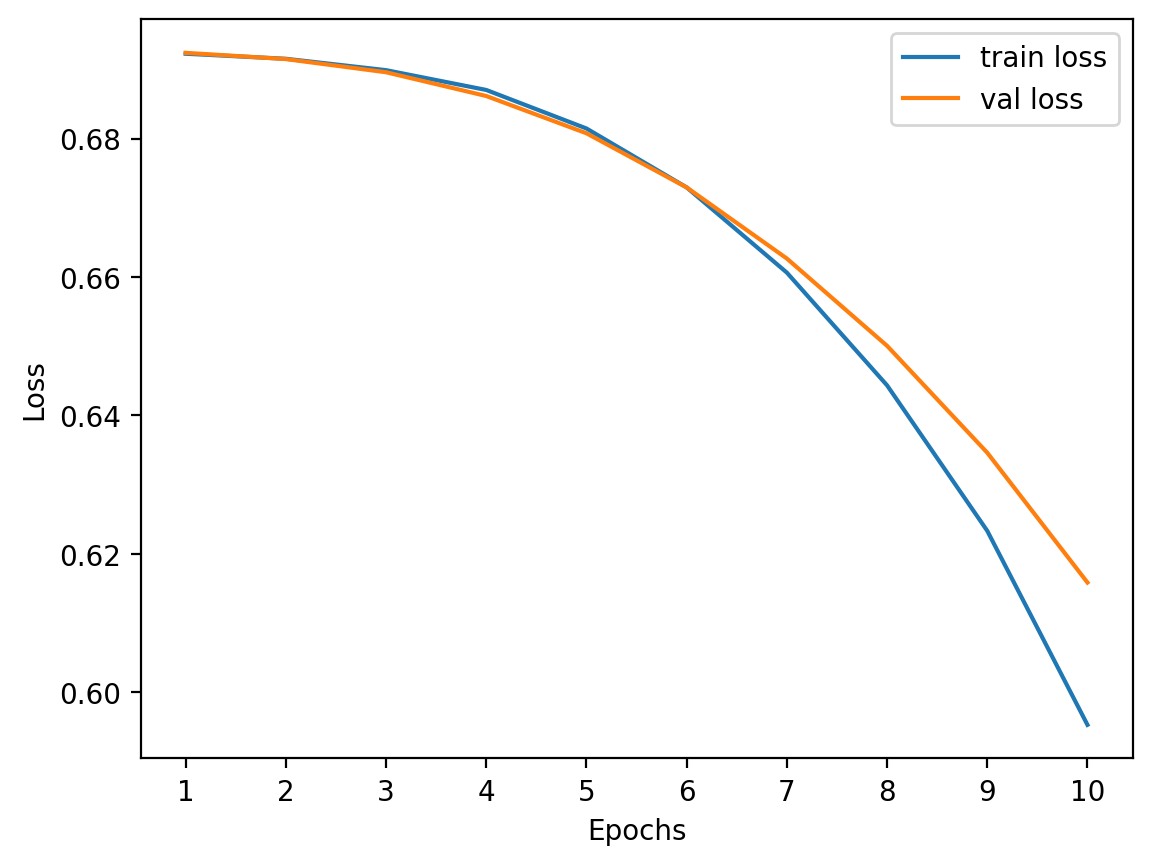

In [165]:
import torch.optim as optim

bow_model = MLP_Model(input_size=10000)
bow_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model.parameters(), lr=0.001)

y_train = y_train.to(torch.long)
y_val = y_val.to(torch.long)

num_epochs = 10

epochs = list(range(1, num_epochs+1))
train_loss_history, val_loss_history = train(bow_model,'models/bow_1.pt', optimizer, criterion, X_train_bow, y_train, X_val_bow, y_val , num_epochs)

plt.plot(epochs , train_loss_history, label='train loss')
plt.plot(epochs , val_loss_history, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()

### Testing on Dataset I

In [166]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def test(model, criterion, X_test, y_test, device):
    model.eval()
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        y_pred_logits = model(X_test)  # shape: (batch_size, 2)
        test_loss = criterion(y_pred_logits, y_test) 
        y_pred_labels = torch.argmax(y_pred_logits, dim=1)  
        
    y_test_np = y_test.cpu().numpy()
    y_pred_np = y_pred_labels.cpu().numpy()

    accuracy = accuracy_score(y_test_np, y_pred_np)
    conf_matrix = confusion_matrix(y_test_np, y_pred_np)

    print(f'Test Loss: {test_loss.item()}')
    print(f'Accuracy: {accuracy:.4f}')

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, conf_matrix

Test Loss: 0.6170946955680847
Accuracy: 0.7342


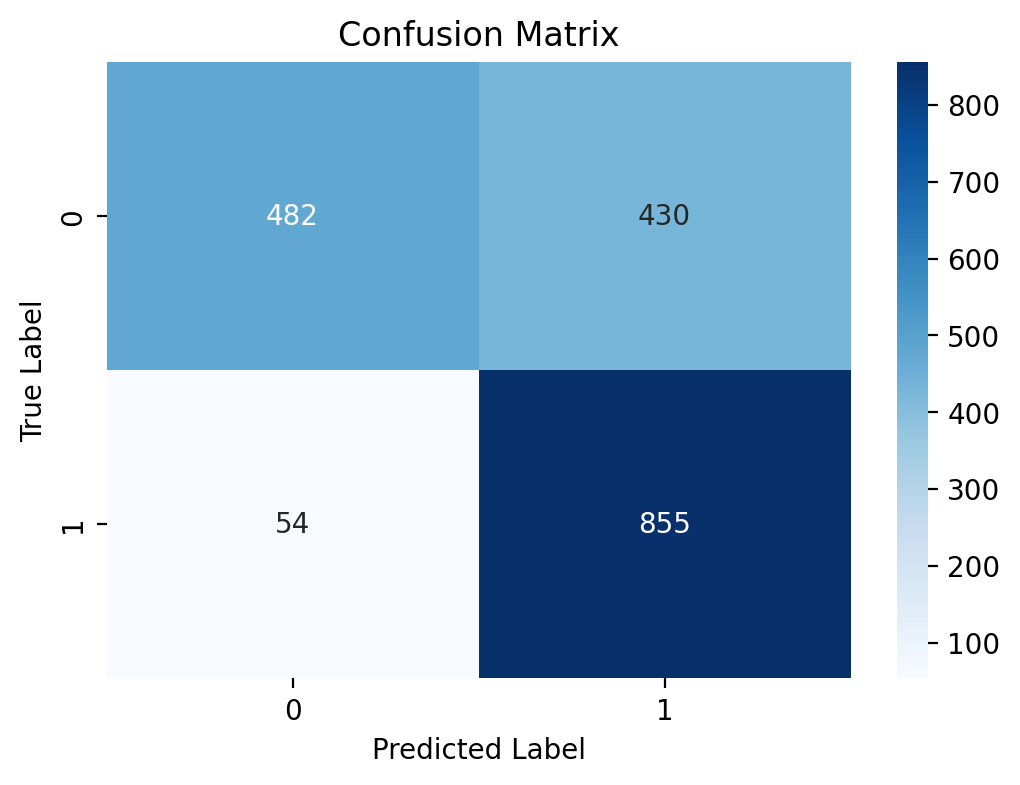

In [167]:
y_test = y_test.to(device).to(torch.long)

accuracy_bow_1 , conf_matrix_bow_1 = test(bow_model, criterion, X_test_bow, y_test, device)

### Training on Dataset II

In [168]:
# using the same vectorizer ( bow ) for imdb dataset
X_train_imdb_bow = vectorizer.transform(imdb_train_df.text)
X_val_imdb_bow = vectorizer.transform(imdb_val_df.text)
X_test_imdb_bow = vectorizer.transform(imdb_test_df.text)

y_train_imdb = imdb_train_df.label
y_val_imdb = imdb_val_df.label
y_test_imdb = imdb_test_df.label

X_train_imdb_bow = torch.tensor(X_train_imdb_bow.toarray(), dtype=torch.float32)
X_val_imdb_bow = torch.tensor(X_val_imdb_bow.toarray(), dtype=torch.float32)
X_test_imdb_bow = torch.tensor(X_test_imdb_bow.toarray(), dtype=torch.float32)

y_train_imdb = torch.tensor(y_train_imdb.values, dtype=torch.int32)
y_val_imdb = torch.tensor(y_val_imdb.values, dtype=torch.int32)
y_test_imdb = torch.tensor(y_test_imdb.values, dtype=torch.int32)

print(X_train_imdb_bow.shape, X_val_imdb_bow.shape, X_test_imdb_bow.shape)
print(y_train_imdb.shape, y_val_imdb.shape, y_test_imdb.shape)

torch.Size([32000, 10000]) torch.Size([8000, 10000]) torch.Size([10000, 10000])
torch.Size([32000]) torch.Size([8000]) torch.Size([10000])


In [169]:
# display the first 10 words in the vocabulary
print({k: vectorizer.vocabulary_[k] for k in list(vectorizer.vocabulary_)[:10]})
print(len(vectorizer.vocabulary_))

{'graphic': np.int64(3619), 'sex': np.int64(8445), 'may': np.int64(5569), 'be': np.int64(485), 'what': np.int64(9837), 'audiences': np.int64(399), 'to': np.int64(9393), 'unfaithful': np.int64(9589), 'but': np.int64(751), 'gripping': np.int64(3669)}
10000


model loaded
Epoch: 1 | Train Loss: 0.5867008566856384 | Val Loss: 0.5017029047012329 | Val Acc: 0.789875
Epoch: 2 | Train Loss: 0.5413033366203308 | Val Loss: 0.5007948875427246 | Val Acc: 0.78
Epoch: 3 | Train Loss: 0.5302952527999878 | Val Loss: 0.5151886343955994 | Val Acc: 0.763125
Epoch: 4 | Train Loss: 0.5404012203216553 | Val Loss: 0.5232975482940674 | Val Acc: 0.75425
Epoch: 5 | Train Loss: 0.540645956993103 | Val Loss: 0.5205368399620056 | Val Acc: 0.7575
Epoch: 6 | Train Loss: 0.5398570895195007 | Val Loss: 0.5100040435791016 | Val Acc: 0.7685
Epoch: 7 | Train Loss: 0.5294145941734314 | Val Loss: 0.4966980814933777 | Val Acc: 0.77975
Epoch: 8 | Train Loss: 0.5198144912719727 | Val Loss: 0.48502108454704285 | Val Acc: 0.791
Epoch: 9 | Train Loss: 0.5119413733482361 | Val Loss: 0.47757869958877563 | Val Acc: 0.801
Epoch: 10 | Train Loss: 0.5085967183113098 | Val Loss: 0.47441205382347107 | Val Acc: 0.80575
Epoch: 11 | Train Loss: 0.5089302659034729 | Val Loss: 0.47322872281074

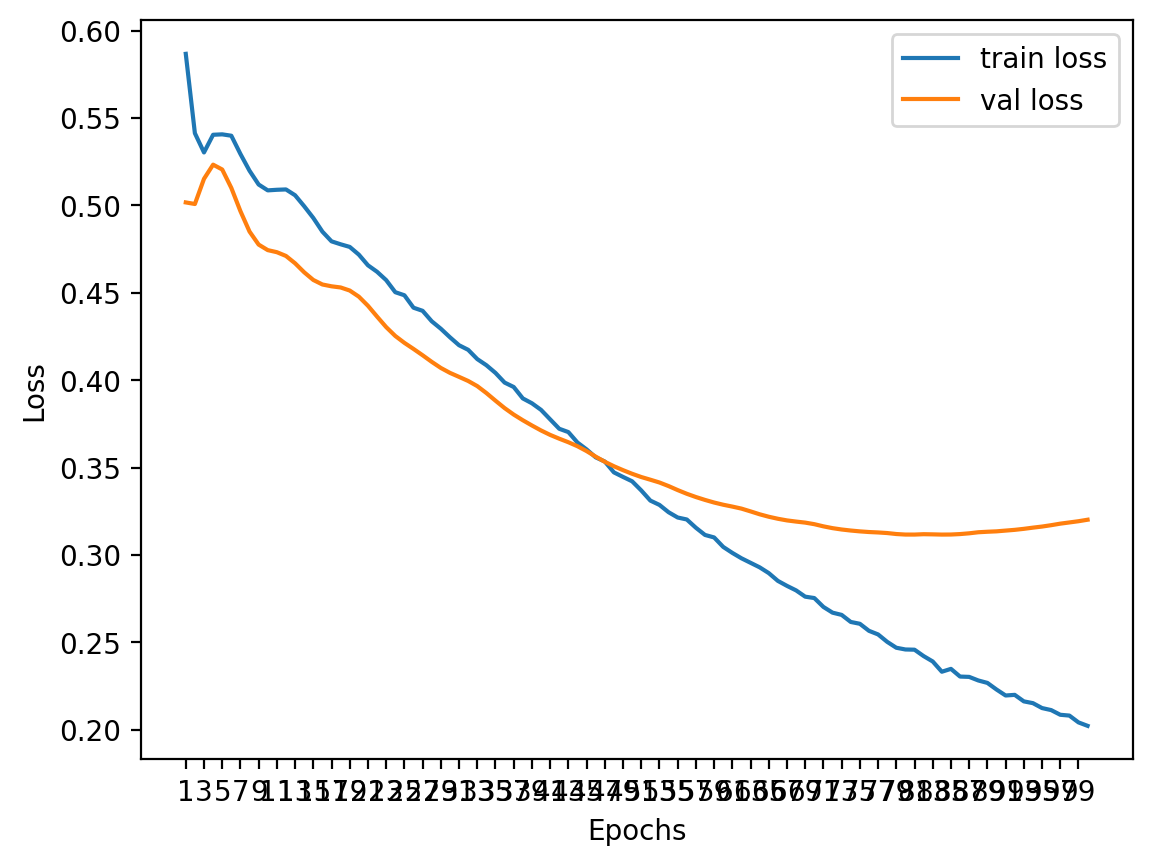

In [177]:
import torch.optim as optim 

# Load the check pointed model
bow_model_2 = MLP_Model(input_size=10000)
bow_model_2.load_state_dict(torch.load('models/bow_1.pt'))
bow_model_2.to(device)

print('model loaded')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bow_model_2.parameters(), lr=0.0001)

y_train_imdb = y_train_imdb.to(torch.long)
y_val_imdb = y_val_imdb.to(torch.long)

num_epochs = 100

epochs = list(range(1, num_epochs+1))
train_loss_history2, val_loss_history2 = train(bow_model_2,'models/bow_2.pt', optimizer, criterion, X_train_imdb_bow, y_train_imdb, X_val_imdb_bow, y_val_imdb , num_epochs)

plt.plot(epochs , train_loss_history2, label='train loss')
plt.plot(epochs , val_loss_history2, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1,2))
plt.legend()
plt.show()

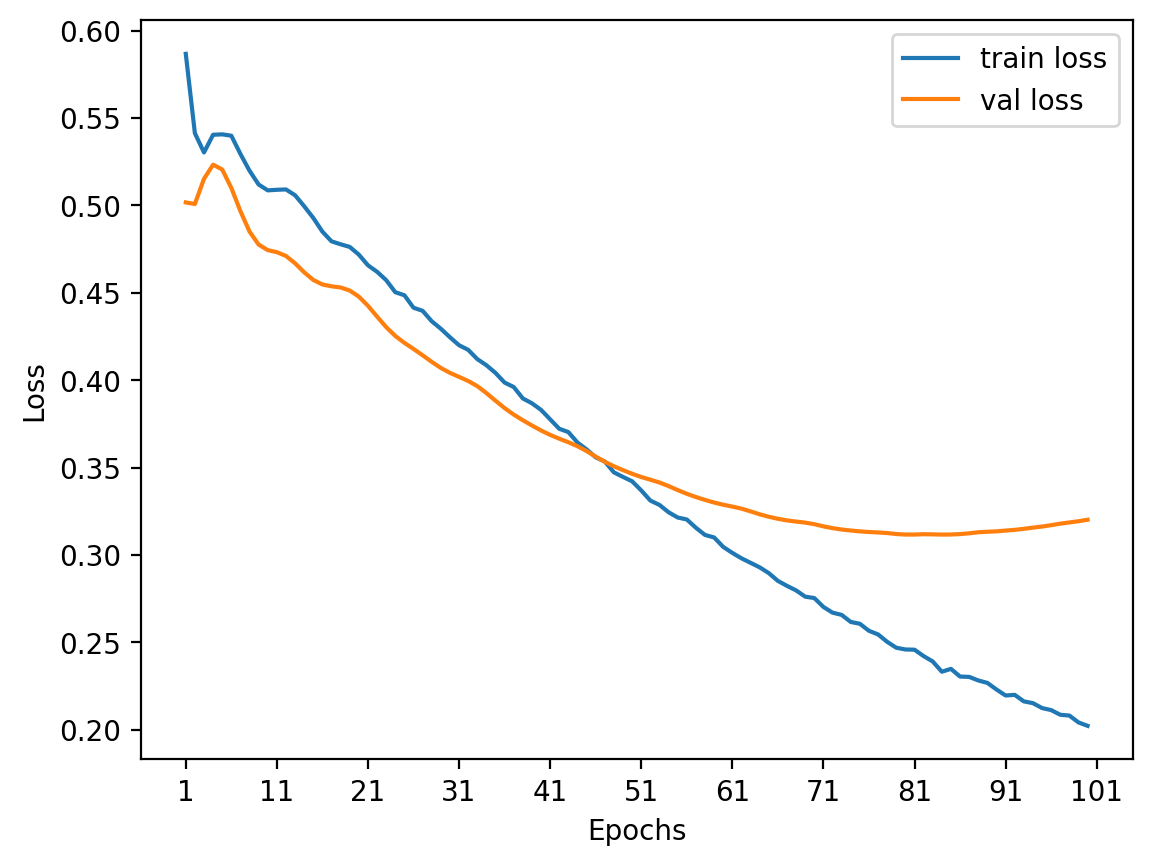

In [181]:
plt.plot(epochs , train_loss_history2, label='train loss')
plt.plot(epochs , val_loss_history2, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+9,10))
plt.legend()
plt.show()

Test Loss: 0.32017746567726135
Accuracy: 0.8894


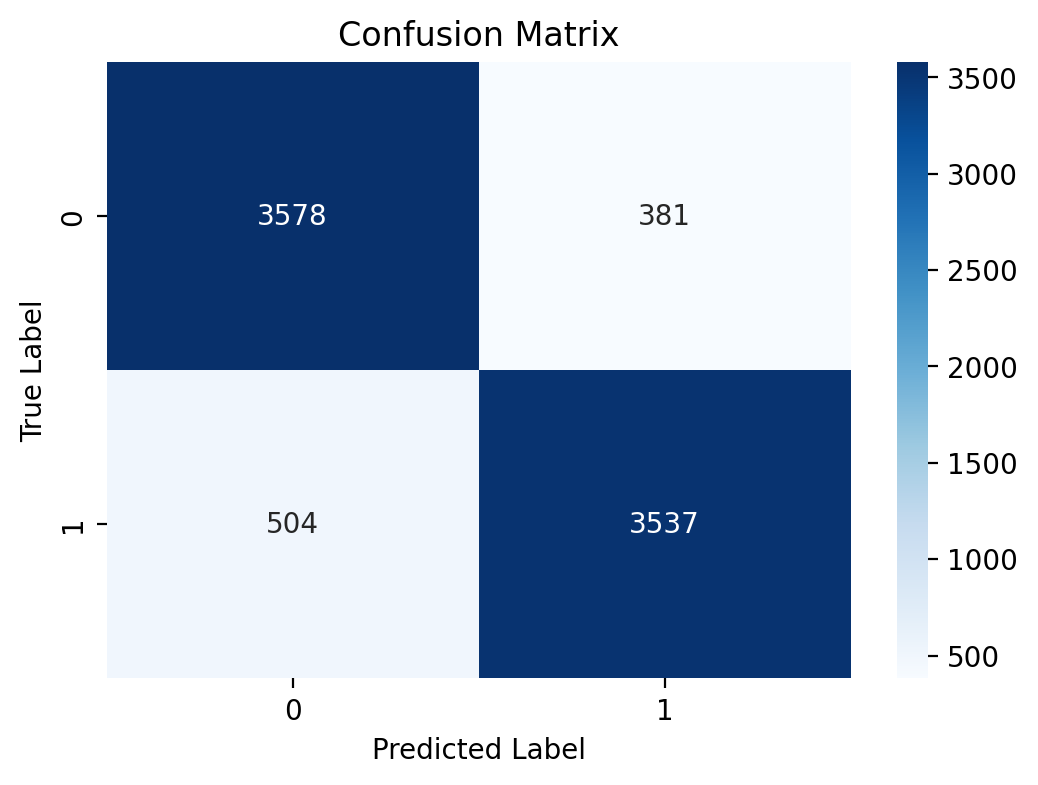

(0.889375,
 array([[3578,  381],
        [ 504, 3537]]))

In [182]:
# accuracy of the best model on validation set
# load best model
bow_model_2.load_state_dict(torch.load('models/bow_2.pt'))
test(bow_model_2, criterion, X_val_imdb_bow, y_val_imdb, device)

### Testing on Dataset II

Test Loss: 0.3153233528137207
Accuracy: 0.8883


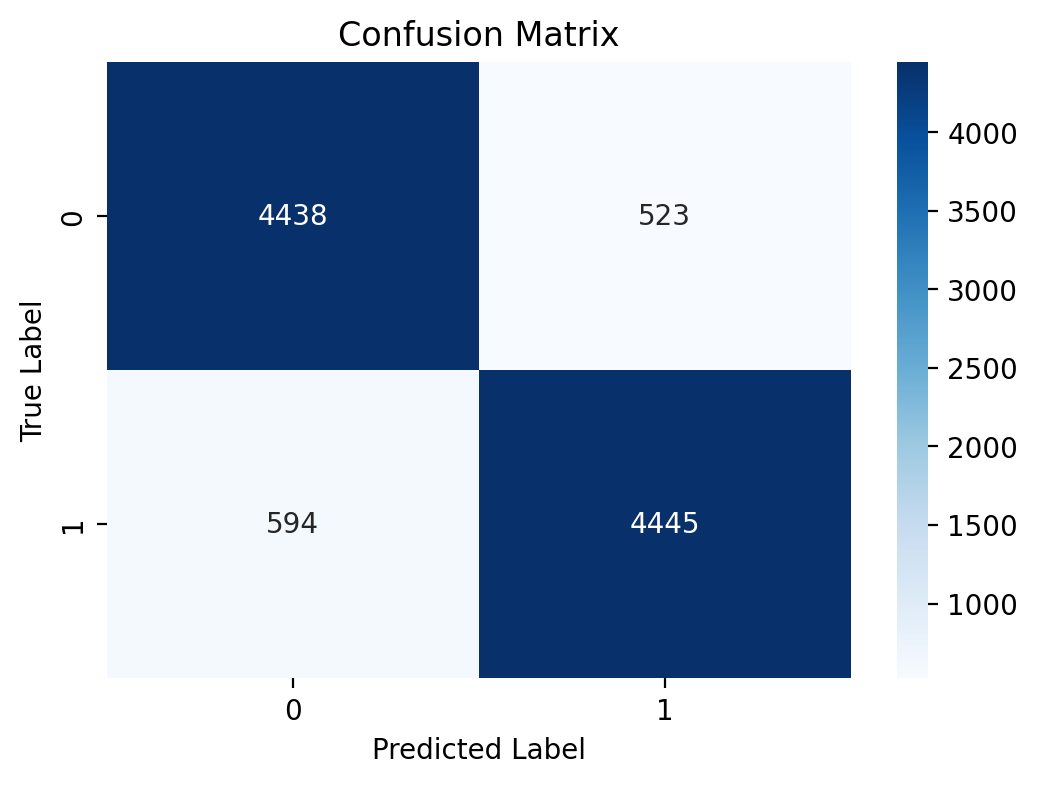

In [183]:
y_test_imdb = y_test_imdb.to(device).to(torch.long)
accuracy_bow_2 , conf_matrix_bow_2 = test(bow_model_2, criterion, X_test_imdb_bow, y_test_imdb, device)

In [184]:
# print few test samples
print(imdb_test_df.text[:10])
print(y_test_imdb[:10])

with torch.no_grad():
    y_pred_logits = bow_model_2(X_test_imdb_bow[:10])
    y_pred_labels = torch.argmax(y_pred_logits, dim=1)

print(y_pred_labels)

0    I really liked this Summerslam due to the look...
1    Not many television shows appeal to quite as m...
2    The film quickly gets to a major chase scene w...
3    Jane Austen would definitely approve of this o...
4    Expectations were somewhat high for me when I ...
5    I've watched this movie on a fairly regular ba...
6    For once a story of hope highlighted over the ...
7    Okay, I didn't get the Purgatory thing the fir...
8    I was very disappointed with this series. It h...
9    The first 30 minutes of Tinseltown had my fing...
Name: text, dtype: object
tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0, 1, 0])
